In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
#Functions
def Calculate_Omega(A,S,Q):
  return np.dot(A,np.dot(S,A.T))+Q

def PartitionMatrix(M,m1):
  M11=M[:m1,:m1]
  M12=M[:m1,m1:]
  M21=M[m1:,:m1]
  M22=M[m1:,m1:]
  return M11,M12,M21,M22

def Calculate_K(Omega,R,m1,Hi):

  O11,O12,O21,O22=PartitionMatrix(Omega,m1)
  R11,R12,R21,R22=PartitionMatrix(R,m1)
  #***
  
  M111=O21
  M112=np.dot(O22,Hi.T)
  M1=np.concatenate([M111,M112],axis=1)


  M211=O11+R11
  M212=R12+np.dot(O12,Hi.T)
  M221=np.dot(Hi,O21)+R21
  M222=np.dot(Hi,np.dot(O22,Hi.T)) + R22
  M2=np.concatenate([np.concatenate([M211,M212],axis=1),np.concatenate([M221,M222],axis=1)],axis=0)
  K=np.dot(M1,np.linalg.inv(M2))
  return K

def Calculate_Sigma(T,Omega):
  return np.dot(T,np.dot(Omega,T.T))
def Update_Omega(A,P,Error_V,V,R,Q):
  return A@P@Error_V@P.T@A.T+A@V@R@V.T@A.T+Q

def initializeObserver(y0,y1,y2,sigma_m_x,sigma_a,T):
  x0_bar=np.array([[y0],[(3/2*y0-2*y1+1/2*y2)/T],[(y0-2*y1+y2)/(T**2)]])
  S0=np.array([[sigma_m_x**2,3*sigma_m_x**2/(2*T),sigma_m_x**2/(T**2)],[3*sigma_m_x**2/(2*T),13*sigma_m_x**2/(T**2)+(T**2) *(sigma_a**2)/16,6*sigma_m_x**2/(T**3)+(sigma_a**2)*T/8],[sigma_m_x**2/(T**2),6*sigma_m_x**2/(T**3)+(sigma_a**2)*T/8,6*sigma_m_x**2/(T**4)+5*(sigma_a**2)*T/4]])
  return x0_bar,S0

def RunObserver(x0_bar,S0,A,Q,R,m1,Steps):
  n=Q.shape[0]
  m=R.shape[0]

  H_i=np.concatenate([np.eye((m-m1)),np.zeros(((m-m1),n-m))],axis=1)

  #Initial Omega

  current_x=np.copy(x0_bar)
  current_S=np.copy(S0)

  Current_Omega=Calculate_Omega(A,current_S,Q)
  Estimates,Sigmas=[],[]
  for i in range(Steps):


    #K Gains
    K=Calculate_K(Current_Omega,R,m1,H_i)
    K1=K[:,:m1]
    K2=K[:,m1:]

    #T P V
    T=np.concatenate([(-K1),np.eye((n-m1))-np.dot(K2,H_i)],axis=1)
    P=np.concatenate([np.zeros((m1,n-m1)),np.eye(n-m1)],axis=0)
    V=np.concatenate([np.concatenate([np.eye(m1),np.zeros((m1,m-m1))],axis=1),K],axis=0)

    #Observer
    z=np.dot(T,np.dot(A,current_x))
    #Estimate
    x_estimate=np.dot(P,z)+np.dot(V,measurement_states[i,:]).reshape(-1,1)

    #Update Omega and x
    Sigma=Calculate_Sigma(T,Current_Omega)
    Omega_new=Update_Omega(A,P,Sigma,V,R,Q)

    current_x=np.copy(x_estimate)
    Current_Omega=np.copy(Omega_new)

    Estimates.append(current_x)
    Sigmas.append(Sigma)

  Estimates=np.array(Estimates)
  Sigmas=np.array(Sigmas)
  return Estimates,Sigmas

In [ ]:
#Create ground truth data
num=200
num_steps=num+2

ground_truth_xs=[]
vo=5
a=2
for t in range(num_steps):
  if t>0:
    ground_truth_xs.append(vo*t+0.5*a*t**2)
  else:
    ground_truth_xs.append(vo*t)

ground_truth_us=np.diff(ground_truth_xs)
ground_truth_as=np.diff(ground_truth_us)

ground_truth_data=np.array([ground_truth_xs[:num],ground_truth_us[:num],ground_truth_as[:num]])

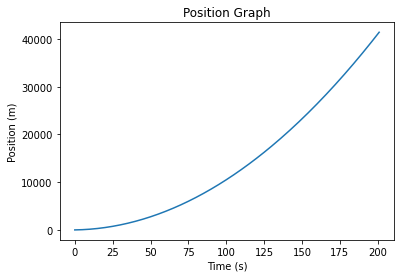

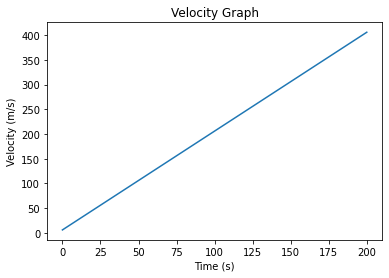

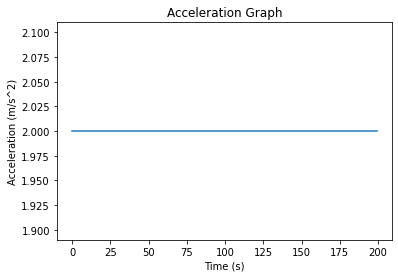

In [ ]:
plt.title('Position Graph')
plt.plot(ground_truth_xs)
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.show()

plt.title('Velocity Graph')
plt.plot(ground_truth_us)
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.show()
plt.title('Acceleration Graph')
plt.plot(ground_truth_as)
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m/s^2)')
plt.show()

In [ ]:
#Defining the system, creating noisy measurements
T=1
A=np.array([[1,T,T**2/2],[0,1,T],[0,0,1]])
#G=np.array([[0],[0],[1]])
H=np.array([[1,0,0],[0,1,0]])

In [ ]:
#Ερώτημα 1 

In [ ]:
#Creating R,Q
sigma_x=10
sigma_v=10
sigma_a=10

sigma_m_x=10
sigma_m_v=10

R=np.array([[sigma_m_x**2,0],[0, sigma_m_v**2]])

Q=np.array([[sigma_x**2,0,0],[0,sigma_v**2,0],[0,0,sigma_a**2]])

#Simulate system predictions
Preds=[ground_truth_data[:,0]]
for i in range(num):
  motion_noise=np.random.multivariate_normal(mean=np.array([0,0,0]), cov=Q)
  new_state=np.dot(A,Preds[-1]) +motion_noise
  Preds.append(new_state)

#Simulate measurements
measurement_states=[ground_truth_data[:2,0]]

for i in range(num-1):
  measurement_noise=np.random.multivariate_normal(mean=np.array([0,0]), cov=R)
  new_measurement= np.dot(H,ground_truth_data[:,i+1]) +measurement_noise
  measurement_states.append(new_measurement)

Preds=np.array(Preds)
measurement_states=np.array(measurement_states)

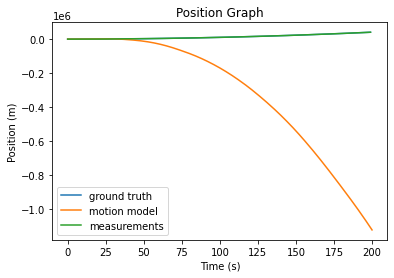

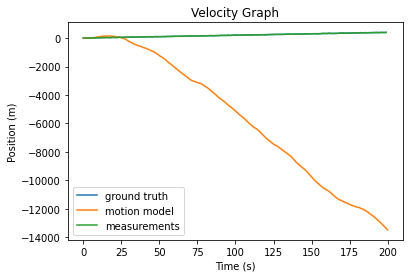

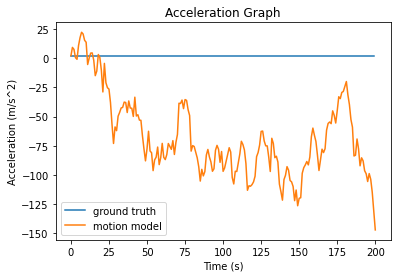

In [ ]:
i=0
plt.title('Position Graph')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.plot(ground_truth_data[i,:])
plt.plot(Preds[:,i])
plt.plot(measurement_states[:,i])
plt.legend(['ground truth','motion model', 'measurements'])
plt.show()
i=1

plt.title('Velocity Graph')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.plot(ground_truth_data[i,:])
plt.plot(Preds[:,i])
plt.plot(measurement_states[:,i])
plt.legend(['ground truth','motion model', 'measurements'])
plt.show()

i=2
plt.title('Acceleration Graph')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m/s^2)')

plt.plot(ground_truth_data[i,:])
plt.plot(Preds[:,i])
plt.legend(['ground truth','motion model'])
plt.show()

In [ ]:
#Initialization1
y0=measurement_states[0,0]
y1=measurement_states[1,0]
y2=measurement_states[2,0]

x0_bar,S0=initializeObserver(y0,y1,y2,sigma_m_x,sigma_a,T)
n=3
m=2
m1=1
Estimates,Sigmas=RunObserver(x0_bar,S0,A,Q,R,m1,num)

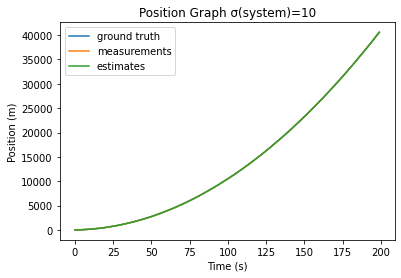

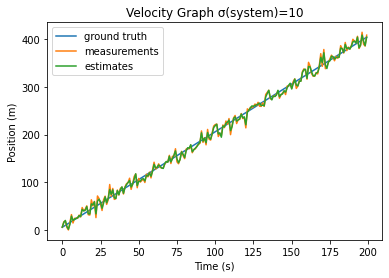

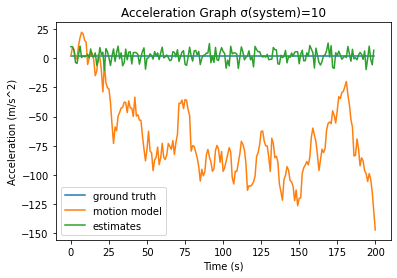

In [ ]:
i=0
plt.title('Position Graph σ(system)='+str(sigma_x))
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.plot(ground_truth_data[i,:])
#plt.plot(Preds[:,i])
plt.plot(measurement_states[:,i])
plt.plot(Estimates[:,i])
#plt.legend(['ground truth','motion model', 'measurements','estimates'])
plt.legend(['ground truth', 'measurements','estimates'])
plt.show()
i=1

plt.title('Velocity Graph σ(system)='+str(sigma_x))
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.plot(ground_truth_data[i,:])
#plt.plot(Preds[:,i])
plt.plot(measurement_states[:,i])
plt.plot(Estimates[:,i])
#plt.legend(['ground truth','motion model', 'measurements','estimates'])
plt.legend(['ground truth', 'measurements','estimates'])
plt.show()

i=2
plt.title('Acceleration Graph σ(system)='+str(sigma_x))
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m/s^2)')

plt.plot(ground_truth_data[i,:])
plt.plot(Preds[:,i])
plt.plot(Estimates[:,i])
plt.legend(['ground truth','motion model','estimates'])
plt.show()

In [ ]:
#Noise

In [ ]:
def violet_noise(samples):
        white = np.fft.rfft(np.random.randn(samples))
        S = np.fft.rfftfreq(samples)
        S = S / np.sqrt(np.mean(S**2))
        X_shaped = white * S
        return np.fft.irfft(X_shaped)

In [ ]:
#Ερώτημα 2

In [ ]:
Violet=[]

sigma_x=10
sigma_v=10
sigma_a=10
std=[sigma_x,sigma_v,sigma_a]

n=3
for i in range(n):
  Violet.append(std[i]*violet_noise(100000000))
Violet=np.array(Violet)
Q=np.array([[np.cov(Violet[0,:]),0,0],[0,np.cov(Violet[1,:]),0],[0,0,np.cov(Violet[2,:])]])

sigma_x=np.std(Violet[0,:])
sigma_v=np.std(Violet[1,:])
sigma_a=np.std(Violet[2,:])

In [ ]:
np.cov(Violet)

array([[ 9.99877773e+01,  1.31290795e-03, -1.44977758e-02],
       [ 1.31290795e-03,  1.00024984e+02, -7.11375987e-03],
       [-1.44977758e-02, -7.11375987e-03,  9.99856815e+01]])

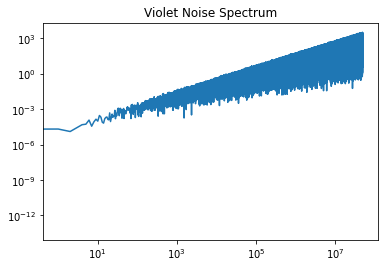

In [ ]:
plt.loglog(np.abs(np.fft.rfft(Violet[0,:])))
plt.title('Violet Noise Spectrum')
plt.show()

In [ ]:
sigma_m_x=10
sigma_m_v=10

R=np.array([[sigma_m_x**2,0],[0, sigma_m_v**2]])

#Simulate system predictions
Preds=[ground_truth_data[:,0]]
for _ in range(num):
  motion_noise=np.array([np.random.choice(Violet[0,:],1),np.random.choice(Violet[1,:],1),np.random.choice(Violet[2,:],1)]).reshape(-1,)
  new_state=np.dot(A,Preds[-1]) +motion_noise
  Preds.append(new_state)

#Simulate measurements
measurement_states=[ground_truth_data[:2,0]]

for i in range(num-1):
  measurement_noise=np.random.multivariate_normal(mean=np.array([0,0]), cov=R)
  new_measurement= np.dot(H,ground_truth_data[:,i+1]) +measurement_noise
  measurement_states.append(new_measurement)

Preds=np.array(Preds)
measurement_states=np.array(measurement_states)

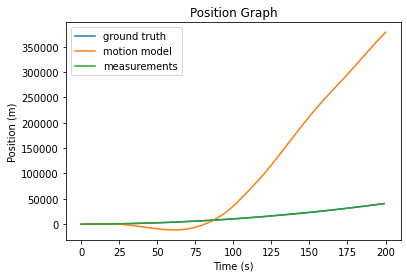

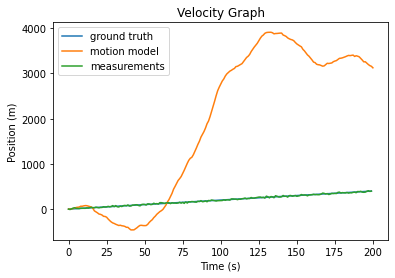

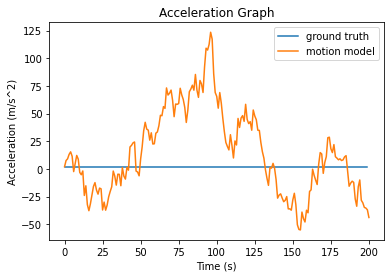

In [ ]:
i=0
plt.title('Position Graph')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.plot(ground_truth_data[i,:])
plt.plot(Preds[:,i])
plt.plot(measurement_states[:,i])
plt.legend(['ground truth','motion model', 'measurements'])
plt.show()
i=1

plt.title('Velocity Graph')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.plot(ground_truth_data[i,:])
plt.plot(Preds[:,i])
plt.plot(measurement_states[:,i])
plt.legend(['ground truth','motion model', 'measurements'])
plt.show()

i=2
plt.title('Acceleration Graph')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m/s^2)')

plt.plot(ground_truth_data[i,:])
plt.plot(Preds[:,i])
plt.legend(['ground truth','motion model'])
plt.show()

In [ ]:
#Initialization
y0=measurement_states[0,0]
y1=measurement_states[1,0]
y2=measurement_states[2,0]
x0_bar,S0=initializeObserver(y0,y1,y2,sigma_m_x,sigma_a,T)

n=3
m=2
m1=1
Estimates,Sigmas=RunObserver(x0_bar,S0,A,Q,R,m1,num)

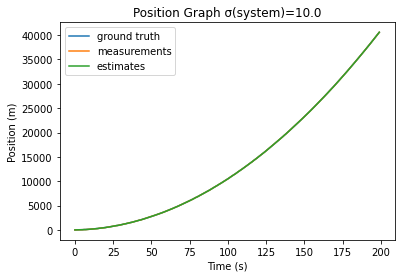

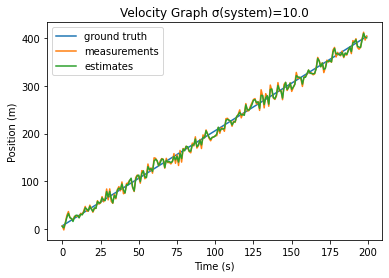

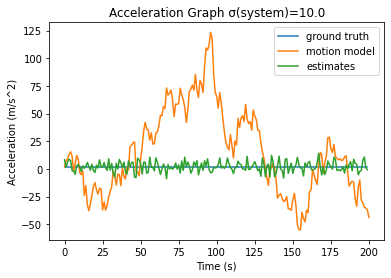

In [ ]:
i=0
plt.title('Position Graph σ(system)='+str(np.ceil(sigma_x)))
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.plot(ground_truth_data[i,:])
#plt.plot(Preds[:,i])
plt.plot(measurement_states[:,i])
plt.plot(Estimates[:,i])
#plt.legend(['ground truth','motion model', 'measurements','estimates'])
plt.legend(['ground truth', 'measurements','estimates'])
plt.show()
i=1

plt.title('Velocity Graph σ(system)='+str(np.ceil(sigma_x)))
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.plot(ground_truth_data[i,:])
#plt.plot(Preds[:,i])
plt.plot(measurement_states[:,i])
plt.plot(Estimates[:,i])
#plt.legend(['ground truth','motion model', 'measurements','estimates'])
plt.legend(['ground truth', 'measurements','estimates'])
plt.show()

i=2
plt.title('Acceleration Graph σ(system)='+str(np.ceil(sigma_x)))
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m/s^2)')

plt.plot(ground_truth_data[i,:])
plt.plot(Preds[:,i])
plt.plot(Estimates[:,i])
plt.legend(['ground truth','motion model','estimates'])
plt.show()

In [ ]:
#Ερώτημα 3
Violet=[]

sigma_m_x=10
sigma_m_v=10

std=[sigma_m_x,sigma_m_v]


n=3
m=2
for i in range(m):
  Violet.append(std[i]*violet_noise(10000000))
Violet=np.array(Violet)
R=np.array([[np.cov(Violet[0,:]),0],[0,np.cov(Violet[1,:])]])

sigma_m_x=np.std(Violet[0,:])
sigma_m_v=np.std(Violet[1,:])

In [ ]:
sigma_m_x,sigma_m_v

(10.003186103881808, 9.9972372960864)

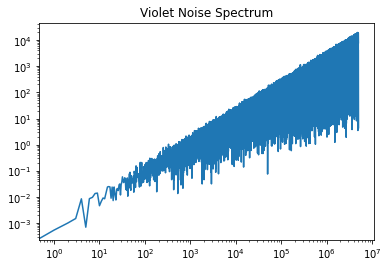

In [ ]:
plt.loglog(np.abs(np.fft.rfft(Violet[0,:])))
plt.title('Violet Noise Spectrum')
plt.show()

In [ ]:
sigma_x=10
sigma_v=10
sigma_a=10

Q=np.array([[sigma_x**2,0,0],[0,sigma_v**2,0],[0,0,sigma_a**2]])

#Simulate system predictions
Preds=[ground_truth_data[:,0]]
for _ in range(num):
  motion_noise=np.random.multivariate_normal(mean=np.array([0,0,0]), cov=Q)
  new_state=np.dot(A,Preds[-1]) +motion_noise
  Preds.append(new_state)

#Simulate measurements
measurement_states=[ground_truth_data[:2,0]]

for i in range(num-1):
  measurement_noise=np.array([np.random.choice(Violet[0,:],1),np.random.choice(Violet[1,:],1)]).reshape(-1,)
  new_measurement= np.dot(H,ground_truth_data[:,i+1]) +measurement_noise
  measurement_states.append(new_measurement)


Preds=np.array(Preds)
measurement_states=np.array(measurement_states)

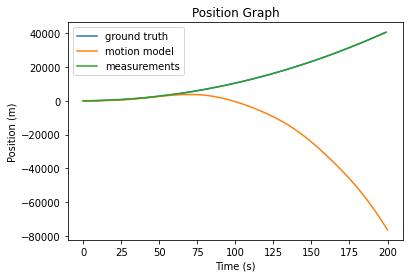

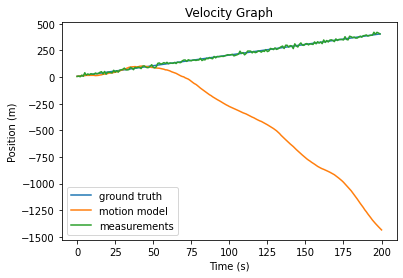

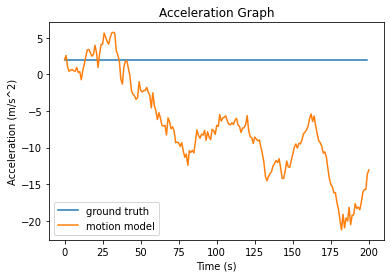

In [ ]:
i=0
plt.title('Position Graph')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.plot(ground_truth_data[i,:])
plt.plot(Preds[:,i])
plt.plot(measurement_states[:,i])
plt.legend(['ground truth','motion model', 'measurements'])
plt.show()
i=1

plt.title('Velocity Graph')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.plot(ground_truth_data[i,:])
plt.plot(Preds[:,i])
plt.plot(measurement_states[:,i])
plt.legend(['ground truth','motion model', 'measurements'])
plt.show()

i=2
plt.title('Acceleration Graph')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m/s^2)')

plt.plot(ground_truth_data[i,:])
plt.plot(Preds[:,i])
plt.legend(['ground truth','motion model'])
plt.show()

In [ ]:
#Initialization
y0=measurement_states[0,0]
y1=measurement_states[1,0]
y2=measurement_states[2,0]
x0_bar,S0=initializeObserver(y0,y1,y2,sigma_m_x,sigma_a,T)

In [ ]:
n=3
m=2
m1=1
Estimates,Sigmas=RunObserver(x0_bar,S0,A,Q,R,m1,num)

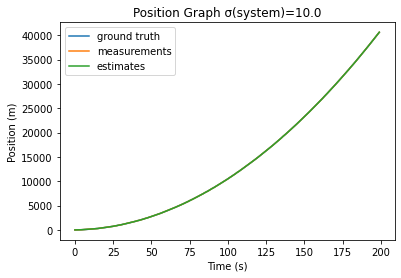

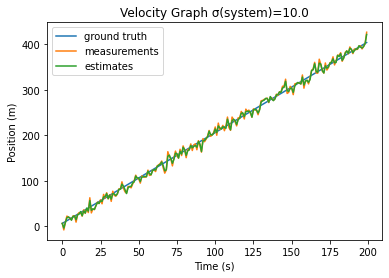

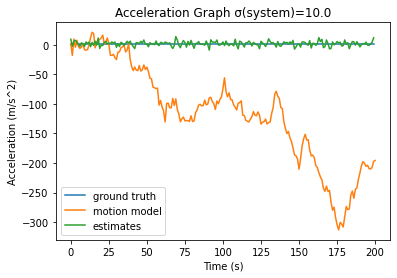

In [ ]:
i=0
plt.title('Position Graph σ(system)='+str(np.ceil(sigma_x)))
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.plot(ground_truth_data[i,:])
#plt.plot(Preds[:,i])
plt.plot(measurement_states[:,i])
plt.plot(Estimates[:,i])
#plt.legend(['ground truth','motion model', 'measurements','estimates'])
plt.legend(['ground truth', 'measurements','estimates'])
plt.show()
i=1

plt.title('Velocity Graph σ(system)='+str(np.ceil(sigma_x)))
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.plot(ground_truth_data[i,:])
#plt.plot(Preds[:,i])
plt.plot(measurement_states[:,i])
plt.plot(Estimates[:,i])
#plt.legend(['ground truth','motion model', 'measurements','estimates'])
plt.legend(['ground truth', 'measurements','estimates'])
plt.show()

i=2
plt.title('Acceleration Graph σ(system)='+str(np.ceil(sigma_x)))
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m/s^2)')

plt.plot(ground_truth_data[i,:])
plt.plot(Preds[:,i])
plt.plot(Estimates[:,i])
plt.legend(['ground truth','motion model','estimates'])
plt.show()

In [ ]:
#Ερώτημα 4

In [ ]:
#Sigmas
sigma_x=10
sigma_v=10
sigma_a=10
sigma_xv=10
sigma_xa=10
sigma_av=10

#Measurements
sigma_m_x=10
sigma_m_v=10
sigma_m_vx=10

R=np.array([[sigma_m_x**2,sigma_m_vx**2],[sigma_m_vx**2, sigma_m_v**2]])
Q=np.array([[sigma_x**2,sigma_xv**2,sigma_xa**2],[sigma_xv**2,sigma_v**2,sigma_av**2],[sigma_xa**2,sigma_av**2,sigma_a**2]])

#Simulate system predictions
Preds=[ground_truth_data[:,0]]
for _ in range(num):
  motion_noise=np.random.multivariate_normal(mean=np.array([0,0,0]), cov=Q)
  new_state=np.dot(A,Preds[-1]) +motion_noise
  Preds.append(new_state)

#Simulate measurements
measurement_states=[ground_truth_data[:2,0]]

for i in range(num-1):
  measurement_noise=np.random.multivariate_normal(mean=np.array([0,0]), cov=R)
  new_measurement= np.dot(H,ground_truth_data[:,i+1]) +measurement_noise
  measurement_states.append(new_measurement)

Preds=np.array(Preds)
measurement_states=np.array(measurement_states)

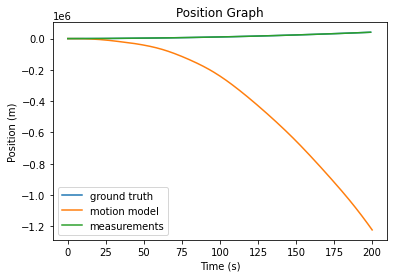

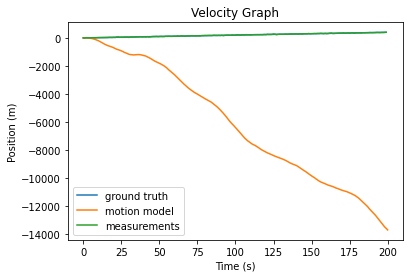

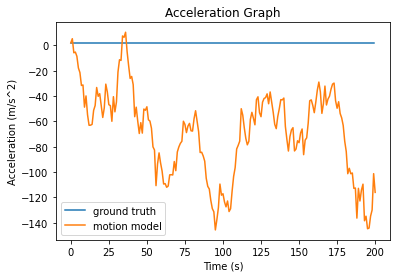

In [ ]:
i=0
plt.title('Position Graph')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.plot(ground_truth_data[i,:])
plt.plot(Preds[:,i])
plt.plot(measurement_states[:,i])
plt.legend(['ground truth','motion model', 'measurements'])
plt.show()
i=1

plt.title('Velocity Graph')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.plot(ground_truth_data[i,:])
plt.plot(Preds[:,i])
plt.plot(measurement_states[:,i])
plt.legend(['ground truth','motion model', 'measurements'])
plt.show()

i=2
plt.title('Acceleration Graph')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m/s^2)')

plt.plot(ground_truth_data[i,:])
plt.plot(Preds[:,i])
plt.legend(['ground truth','motion model'])
plt.show()

In [ ]:
#Initialization1
y0=measurement_states[0,0]
y1=measurement_states[1,0]
y2=measurement_states[2,0]

x0_bar,S0=initializeObserver(y0,y1,y2,sigma_m_x,sigma_a,T)

In [ ]:
n=3
m=2
m1=1
Estimates,Sigmas=RunObserver(x0_bar,S0,A,Q,R,m1,num)

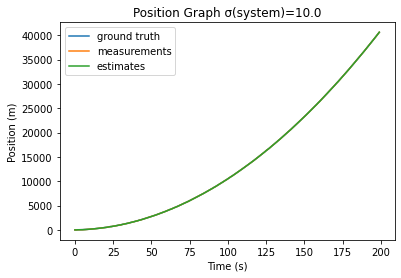

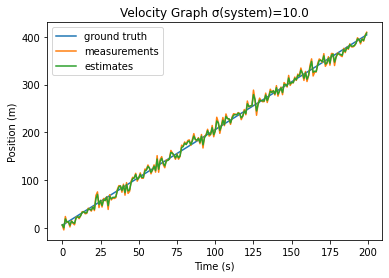

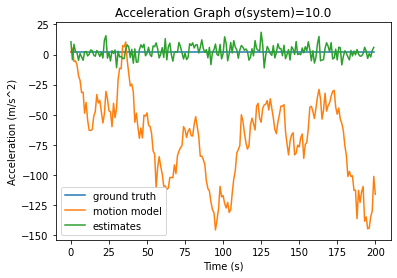

In [ ]:
i=0
plt.title('Position Graph σ(system)='+str(np.ceil(sigma_x)))
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.plot(ground_truth_data[i,:])
#plt.plot(Preds[:,i])
plt.plot(measurement_states[:,i])
plt.plot(Estimates[:,i])
#plt.legend(['ground truth','motion model', 'measurements','estimates'])
plt.legend(['ground truth', 'measurements','estimates'])
plt.show()
i=1

plt.title('Velocity Graph σ(system)='+str(np.ceil(sigma_x)))
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.plot(ground_truth_data[i,:])
#plt.plot(Preds[:,i])
plt.plot(measurement_states[:,i])
plt.plot(Estimates[:,i])
#plt.legend(['ground truth','motion model', 'measurements','estimates'])
plt.legend(['ground truth', 'measurements','estimates'])
plt.show()

i=2
plt.title('Acceleration Graph σ(system)='+str(np.ceil(sigma_x)))
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m/s^2)')

plt.plot(ground_truth_data[i,:])
plt.plot(Preds[:,i])
plt.plot(Estimates[:,i])
plt.legend(['ground truth','motion model','estimates'])
plt.show()